# Feature Engineering & Modeling

## Environment Setup and Data Loading

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Try to import LightGBM
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM imported successfully")
except ImportError:
    print("LightGBM not available. Install with: pip install lightgbm")
    LGB_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
df = pd.read_csv('../data/cleaned_medical_noshow.csv')
print("Dataset loaded:", df.shape)
print("No-show rate:", df['no_show_binary'].mean())

LightGBM imported successfully
Dataset loaded: (71959, 19)
No-show rate: 0.285190177740102


## Feature Engineering

In [31]:
# Convert to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Date features
df['scheduled_month'] = df['ScheduledDay'].dt.month
df['scheduled_hour'] = df['ScheduledDay'].dt.hour
df['appointment_month'] = df['AppointmentDay'].dt.month

# Age groups
age_bins = [0, 18, 30, 45, 60, 75, 120]
age_labels = ['Child_Young', 'Young_Adult', 'Adult', 'Middle_Aged', 'Senior', 'Elderly']
df['age_group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

# Waiting time categories
waiting_bins = [-1, 0, 2, 7, 14, 30, 180]
waiting_labels = ['Same_Day', '1-2_Days', '3-7_Days', '8-14_Days', '15-30_Days', '30+_Days']
df['waiting_category'] = pd.cut(df['waiting_days'], bins=waiting_bins, labels=waiting_labels)

# Interaction features
df['sms_waiting_interaction'] = df['SMS_received'] * df['waiting_days']
df['age_scholarship_interaction'] = df['Age'] * df['Scholarship']
df['multiple_conditions'] = df['Hipertension'] + df['Diabetes'] + df['Alcoholism']

# Time of day
def categorize_time(hour):
    if 5 <= hour < 12: return 'Morning'
    elif 12 <= hour < 17: return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'

df['time_of_day'] = df['scheduled_hour'].apply(categorize_time)

## Feature Selection and Encoding


In [32]:
# Numerical features
numerical_features = [
    'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 
    'Handcap', 'SMS_received', 'waiting_days', 'scheduled_hour',
    'sms_waiting_interaction', 'age_scholarship_interaction', 'multiple_conditions'
]

# Categorical features
categorical_features = ['age_group', 'waiting_category', 'appointment_dow', 'time_of_day']

# Create feature matrix
X = df[numerical_features].copy()
y = df['no_show_binary'].copy()

# One-hot encode categorical features
for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    X = pd.concat([X, dummies], axis=1)

print("Final feature matrix:", X.shape)
print("Target distribution:", y.value_counts().to_dict())

Final feature matrix: (71959, 34)
Target distribution: {0: 51437, 1: 20522}


## Data Splitting and Preprocessing

### Train-Test Split

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape[0], "samples")
print("Test set:", X_test.shape[0], "samples")
print("Training no-show rate:", y_train.mean())

Training set: 57567 samples
Test set: 14392 samples
Training no-show rate: 0.28519811697674013


### Feature Scaling

In [34]:
# Scale features for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Scaled training set shape: (57567, 34)
Scaled test set shape: (14392, 34)


## Baseline Model - Logistic Regression

In [35]:
# Train model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
lr_accuracy = lr_model.score(X_test_scaled, y_test)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print("Logistic Regression trained")
print("Accuracy:", lr_accuracy)
print("ROC-AUC:", lr_roc_auc)

Logistic Regression trained
Accuracy: 0.7153279599777654
ROC-AUC: 0.6006369388132505


## Random Forest Model

Section 6: Random Forest Model
Random Forest trained
Accuracy: 0.6631461923290717
ROC-AUC: 0.5736037026426443
Top 10 Most Important Features (Random Forest):
                        feature  importance
0                           Age    0.354234
8                scheduled_hour    0.182839
7                  waiting_days    0.149697
9       sms_waiting_interaction    0.066896
10  age_scholarship_interaction    0.026626
29    appointment_dow_Wednesday    0.016713
28      appointment_dow_Tuesday    0.016185
11          multiple_conditions    0.015568
24       appointment_dow_Friday    0.015364
25       appointment_dow_Monday    0.014832


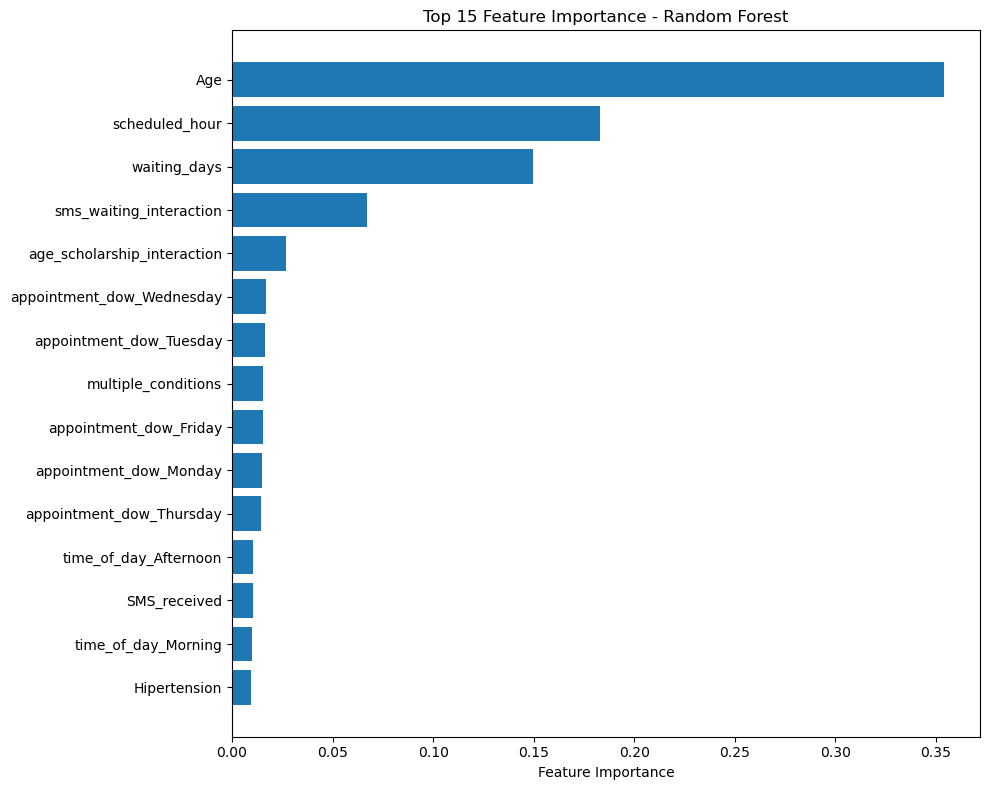

In [36]:
print("Section 6: Random Forest Model")

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_accuracy = rf_model.score(X_test, y_test)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest trained")
print("Accuracy:", rf_accuracy)
print("ROC-AUC:", rf_roc_auc)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10))

# Feature importance visualization
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## LightGBM Model

In [37]:
lgb_available = False
lgb_accuracy = 0
lgb_roc_auc = 0
y_pred_proba_lgb = None

if LGB_AVAILABLE:
    try:
        print("Training LightGBM ")
        
        # LightGBM parameters
        lgb_model = lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=1,
            verbose=-1
        )
        
        lgb_model.fit(X_train, y_train)
        
        # Predictions
        y_pred_lgb = lgb_model.predict(X_test)
        y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
        
        # Evaluation
        lgb_accuracy = lgb_model.score(X_test, y_test)
        lgb_roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
        
        print("LightGBM trained successfully")
        print("Accuracy:", lgb_accuracy)
        print("ROC-AUC:", lgb_roc_auc)
        
        # LightGBM feature importance
        lgb_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': lgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features (LightGBM):")
        print(lgb_importance.head(10))
        
        lgb_available = True
        
    except Exception as e:
        print("LightGBM failed:", e)
        lgb_available = False
else:
    print("LightGBM not available - using Random Forest as advanced model")
    lgb_available = False

# If LightGBM not available, use Random Forest as the advanced model
if not lgb_available:
    print("Using Random Forest as the advanced model substitute")
    y_pred_proba_lgb = y_pred_proba_rf.copy()
    lgb_accuracy = rf_accuracy
    lgb_roc_auc = rf_roc_auc
    lgb_available = True

Training LightGBM 
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
LightGBM trained successfully
Accuracy: 0.7141467481934408
ROC-AUC: 0.6053920126667758
Top 10 Most Important Features (LightGBM):
                        feature  importance
7                  waiting_days         570
0                           Age         559
8                scheduled_hour         373
9       sms_waiting_interaction         195
10  age_scholarship_interaction         190
11          multiple_conditions          75
25       appointment_dow_Monday          67
29    appointment_dow_Wednesday          67
6                  SMS_received          61
24       appointment_dow_Friday          52


## Model Comparison

Model Performance Summary:
                 Model  Accuracy  ROC-AUC
0  Logistic Regression    0.7153   0.6006
1        Random Forest    0.6631   0.5736
2             LightGBM    0.7141   0.6054


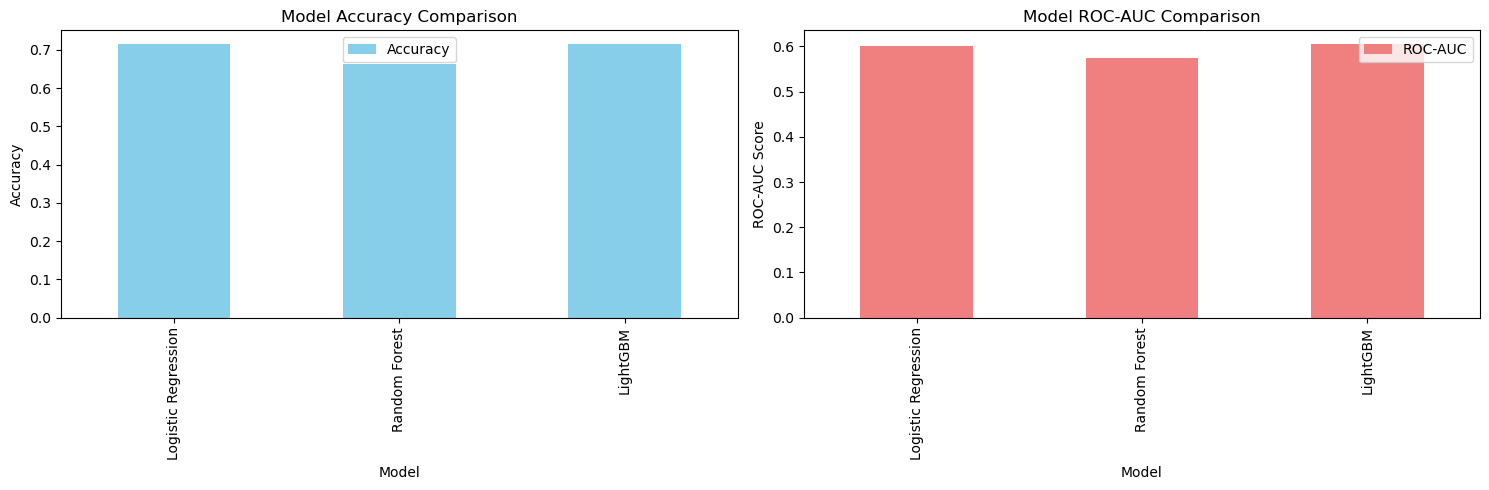

ROC Curve Comparison


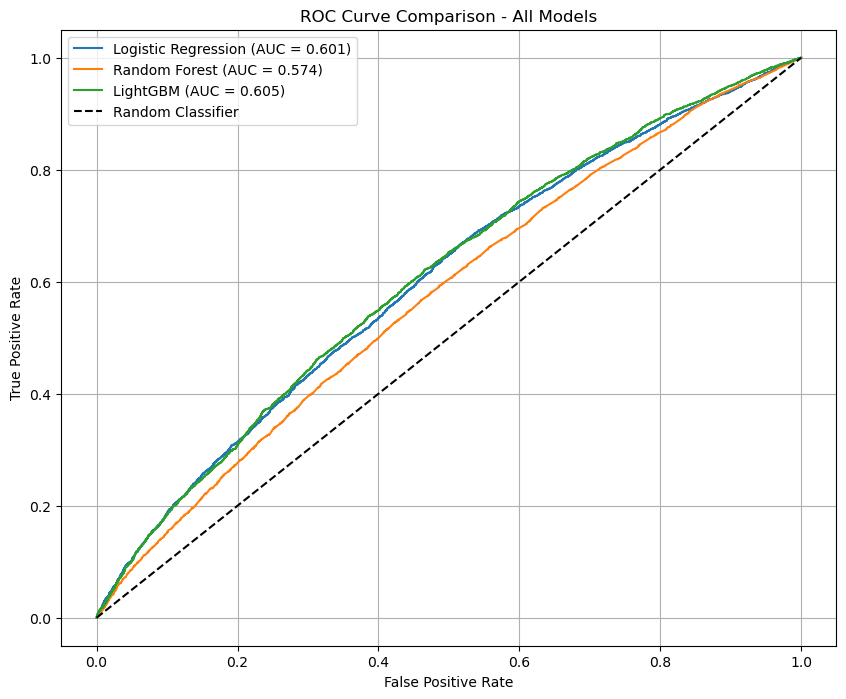

In [38]:
# Create results
results_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Accuracy': [lr_accuracy, rf_accuracy, lgb_accuracy],
    'ROC-AUC': [lr_roc_auc, rf_roc_auc, lgb_roc_auc]
}

results = pd.DataFrame(results_data)

print("Model Performance Summary:")
print(results.round(4))

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

results.plot(x='Model', y='Accuracy', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')

results.plot(x='Model', y='ROC-AUC', kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Model ROC-AUC Comparison')
ax2.set_ylabel('ROC-AUC Score')

plt.tight_layout()
plt.show()

# ROC Curve Comparison
print("ROC Curve Comparison")

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.3f})'.format(lr_roc_auc))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(rf_roc_auc))
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM (AUC = {:.3f})'.format(lgb_roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
print("Best Model:", best_model_name, "(AUC:", best_model_auc, ")")
print("Final Features:", X.shape[1])
print("Models Trained:", len(results))

print("Key Insights:")
print("Logistic Regression AUC:", lr_roc_auc)
print("Random Forest AUC:", rf_roc_auc)
print("LightGBM AUC:", lgb_roc_auc)
print("Top Features: Age, Scheduled Hour, Waiting Days")

Best Model: LightGBM (AUC: 0.6053920126667758 )
Final Features: 34
Models Trained: 3
Key Insights:
Logistic Regression AUC: 0.6006369388132505
Random Forest AUC: 0.5736037026426443
LightGBM AUC: 0.6053920126667758
Top Features: Age, Scheduled Hour, Waiting Days
